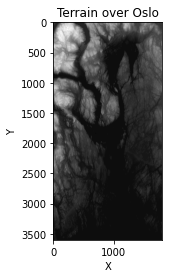

In [2]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain1 = imread('../reference_material/oslo.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Oslo')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

[[148 148 149 ... 147 147 148]
 [150 151 152 ... 145 145 145]
 [153 154 154 ... 144 144 143]
 ...
 [ 78  71  64 ...   0   0   0]
 [ 79  71  63 ...   0   0   0]
 [ 75  68  60 ...   0   0   0]]
